In [73]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import ast
import nltk
nltk.download('punkt')

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/constantinernstberger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
PART = "presentation_summary"
#PART = "qna_summary"

# Initialize columns for each emotion
ORIGINAL = True

df = pd.read_csv("transcripts/credit_df.csv", delimiter="|")

if ORIGINAL:
    emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]
else:
    emotions = ['positive', 'negative', 'ambiguous']

In [ ]:
'''Follow intructions on https://github.com/monologg/GoEmotions-pytorch to download the model and tokenizer'''

from transformers import BertTokenizer
from model import BertForMultiLabelClassification
from multilabel_pipeline import MultiLabelPipeline

original = True

if original:
  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
else:
  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-group")
  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-group")

goemotions = MultiLabelPipeline(
    model=model,
    tokenizer=tokenizer,
    threshold=0.3
)

df[f'{PART}_scores'] = None

# Process each earnings call
for idx, transcript in enumerate(df[PART]):
  try:
    call = nltk.sent_tokenize(transcript)  # Tokenize sentences from the cleaned text
    scores = goemotions(call)  # Assuming `goemotions` processes the sentences and returns emotion scores
    df.at[idx, f'{PART}_scores'] = scores
    print(idx)
  except:
    df.at[idx, f'{PART}_scores'] = []
    print(idx)

df.to_csv(f'goemotions/emotion_scores_{PART}.csv', sep='|')

In [80]:
scores = pd.read_csv(f'goemotions/emotion_scores_{PART}.csv', delimiter='|')

# Convert strings in 'presentation_summary_scores' to actual lists
scores[f'{PART}_scores'] = scores[f'{PART}_scores'].apply(ast.literal_eval)

scores.head()

,call_ID,aggregated_RR,presentation,QnA,presentation_summary,presentation_summary_scores
0,0,29.023972,Presentation\nOperator\nGood morning Ladies an...,Question and Answer\nOperator\n[Operator Instr...,Good morning everyone. I will begin my remarks...,"[{'labels': ['neutral'], 'scores': [0.99079496..."
1,1,8.869420,"Presentation\nOperator\nLadies and gentlemen, ...",Question and Answer\nOperator\n(Operator Instr...,"Thank you, operator. As you can tell, we have ...","[{'labels': ['gratitude'], 'scores': [0.996631..."
2,2,33.210455,Presentation\nOperator\nGreetings ladies and g...,Question and Answer\nOperator\nThank you. Ladi...,"During the quarter, our unrestricted cash bala...","[{'labels': ['neutral'], 'scores': [0.97970974..."
3,3,11.875000,"Presentation\nOperator\nThank you, all parties...",Question and Answer\nOperator\n[Operator Instr...,We finished the quarter at a debt level of jus...,"[{'labels': ['realization', 'neutral'], 'score..."
4,4,18.340000,Presentation\nOperator\nThank you for joining ...,Question and Answer\nOperator\n(Operator Instr...,Interest expense increased $6.6 million due to...,"[{'labels': ['neutral'], 'scores': [0.99706775..."


In [81]:
# Initialize columns for each emotion in the DataFrame
for emotion in emotions:
    scores[emotion] = 0.0

# Process each transcript's scores and calculate the emotion features
for idx, row in scores.iterrows():
    # Initialize a dictionary to hold total emotion scores
    emotion_scores = {emotion: 0.0 for emotion in emotions}
    
    # Get the list of sentence scores
    sentence_scores = row[f'{PART}_scores']
    sentence_count = len(sentence_scores)
    
    # Accumulate scores for each emotion
    for entry in sentence_scores:
        for label, score in zip(entry['labels'], entry['scores']):
            if label in emotion_scores:
                emotion_scores[label] += score

    # Normalize the scores by the number of sentences (average per sentence)
    for emotion, total_score in emotion_scores.items():
        scores.at[idx, emotion] = total_score / sentence_count if sentence_count > 0 else 0.0

In [82]:
bond_level = pd.read_csv('transcripts/credit_df.csv', delimiter='|')  

# merge output_df with transcripts on 'transcript_number' and index
bond_level = pd.merge(bond_level,
                          scores[emotions + ['call_ID']],
                          on=['call_ID'],
                          how='left')

# normalize all emotion columns
scaler = MinMaxScaler()
bond_level[emotions] = scaler.fit_transform(bond_level[emotions])

checkpoint = bond_level.copy()

In [83]:
checkpoint.to_csv(f'goemotions/{PART}_final.csv', sep='|')

In [60]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + emotions
                    ]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [62]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     18.28
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.10e-61
Time:                        09:43:04   Log-Likelihood:                -4840.9
No. Observations:                1075   AIC:                             9730.
Df Residuals:                    1051   BIC:                             9849.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.7951      3.655      5.

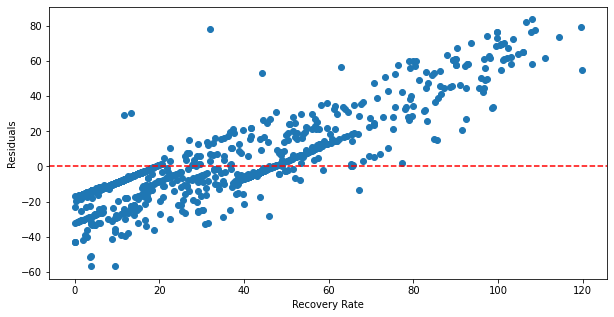

In [63]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [64]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

          Features        VIF
0            const  29.403905
2            anger   2.776850
12      excitement   1.941279
9   disappointment   1.728193
6        confusion   1.650385
1       admiration   1.640373
10     disapproval   1.580773
3        annoyance   1.419800
7        curiosity   1.380146
17        optimism   1.373659
4         approval   1.347672
22         sadness   1.328390
5           caring   1.292020
19     realization   1.284845
15             joy   1.250969
14       gratitude   1.244010
8           desire   1.238218
13            fear   1.228999
21         remorse   1.191205
18           pride   1.173443
20          relief   1.139736
23        surprise   1.092188
16     nervousness   1.079658
11   embarrassment   1.065478


In [65]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

          Features        VIF
0            const  29.403905
2            anger   2.776850
12      excitement   1.941279
9   disappointment   1.728193
6        confusion   1.650385
1       admiration   1.640373
10     disapproval   1.580773
3        annoyance   1.419800
7        curiosity   1.380146
17        optimism   1.373659
4         approval   1.347672
22         sadness   1.328390
5           caring   1.292020
19     realization   1.284845
15             joy   1.250969
14       gratitude   1.244010
8           desire   1.238218
13            fear   1.228999
21         remorse   1.191205
18           pride   1.173443
20          relief   1.139736
23        surprise   1.092188
16     nervousness   1.079658
11   embarrassment   1.065478


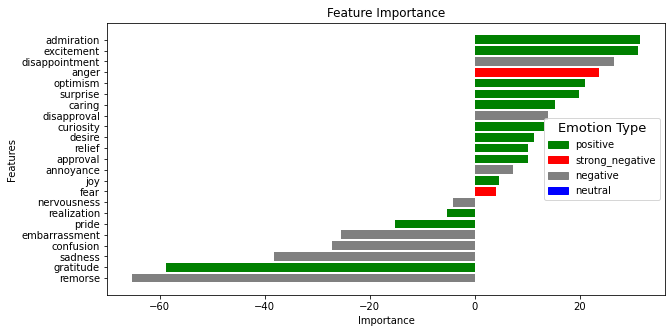

In [70]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Define emotion types (you can adjust this based on the actual emotional categories)
emotion_types = {
    #'negative': 'negative',
    #'ambiguous': 'neutral',
    'relief': 'positive',
    'remorse': 'negative',
    #'positive': 'positive',
    'nervousness': 'negative',
    'desire': 'positive',
    'fear': 'strong_negative',
    'excitement': 'positive',
    'confusion': 'negative',
    'pride': 'positive',
    'annoyance': 'negative',
    'gratitude': 'positive',
    'anger': 'strong_negative',
    'optimism': 'positive',
    'sadness': 'negative', 
    'approval': 'positive',
    'caring': 'positive',
    'disappointment': 'negative',
    'curiosity': 'positive',
    'surprise': 'positive',
    'admiration': 'positive',
    'embarrassment': 'negative',
    'realization': 'positive',
    'disapproval': 'negative',
    'joy': 'positive'
}

# Map colors to each emotion type
color_mapping = {
    'positive': 'green',
    'strong_negative': 'red',
    'negative': 'gray',
    'neutral': 'blue'
}

# Apply the color mapping to the importances
colors = [color_mapping[emotion_types[emotion]] for emotion in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
# add a legend to the right of the plot
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color_mapping[emotion], label=emotion) for emotion in color_mapping]
plt.legend(handles=handles, title='Emotion Type', title_fontsize='13', loc='right', bbox_to_anchor=(1, 0.5))
plt.show()